In [1]:
LAST_TRAINSET_TIME = 29 # 29 for develop, 32 for submit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
totalstart=time()
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor, plot_importance

pd.set_option('display.max_columns', 100)

%matplotlib inline

figsize = (6,14)

def plot_importances(model, error=False, title=''):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)#[::-1]

    fig, ax = plt.subplots(figsize=figsize)
    if error:
        std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
        plt.barh(range(train_X.shape[1]), importances[indices], xerr=std[indices], align="center")
    else:
        plt.barh(range(train_X.shape[1]), importances[indices], align="center")

    plt.yticks(range(train_X.shape[1]), [train_X.columns[ix] for ix in indices], rotation='horizontal')
    plt.ylim([-1, train_X.shape[1]])
    ax.xaxis.tick_top()
    plt.title(title, y=1.03)
    plt.show()

def plot_xgboost_importances(booster, model_name):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax, height=0.8, title=model_name+' - uses', importance_type='weight')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax, height=0.8, title=model_name+' - avg gain', importance_type='gain')
    plt.show()
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax, height=0.8, title=model_name+' - avg affected samples', importance_type='cover')
    plt.show()

def plot_tree_usefulness(model, validate_X, validate_y, model_name):
    predictions = []
    for tree in model.estimators_:
        predictions.append(tree.predict(validate_X))
        
    predictions = np.vstack(predictions)
    predictions = np.cumsum(predictions, axis=0)
    predictions = [predictions[i]/(i+1) for i in range(len(predictions))] #cum mean

    scores = []
    for pred in predictions:
        scores.append(np.sqrt(MSE(pred, validate_y)))
        
    plt.figure(figsize=(8, 4))
    plt.plot(scores, linewidth=3)
    plt.xlabel('trees')
    plt.ylabel('rmse')
    plt.title(model_name+' tree usefulnesses')
    plt.show()

In [2]:
model_features = [
    'count', # label, dropped later
    'item', # need for prediction S,S,3,
    'shop', # need for prediction S,S,S,
    'time', # need for prediction 3,S,3,3
    
    'shop_city', # S,S,S,3x trash candidate, all trash
    'shop_type', # S,S,S,3x trash candidate, all trash
    'category', # S,S,S,3k trash candidate, cheaps trash
    'larger_category', # S,S,S,3x trash candidate, all trash
    'item_return_percent', # S,3,-,
    
    'month', # 3,-,-,3 cheap candidate, old cheap
    #'year', # S,S,S,
    #'month_length', # S,S,S,
    #'holidays_in_month', # S,S,S,
    
    #'shop_mean_count', # S,S,33,3
    'category_mean_count', # S,3,S,
    'item_mean_count', # 3,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
    'shop_item_mean_count', # 1,-,-, cheap candidate, old cheap, chosen cheap, best cheap subset
    'shop_category_mean_count', # S,2,-,2 cheap candidate, best cheap subset
    
    'count_trend', # 3,3,-,3 cheap additional
    'item_count_trend', # 2,2,-, cheap candidate
    'item_price_trend', # S,S,S,2k trash candidate
    'months_since_first_item_sale', # 2,3,-, cheap candidate
    'months_since_last_item_sale', # S3,S3,-,3 cheap additional
    'months_since_first_sale', # 2,2,-, cheap candidate
    'months_since_last_sale', # 3,3,-,3
    
    'item_name_vector_1', # S,S,S32, trash candidate, all trash
    'item_name_vector_2', # S,S,S3, trash candidate, all trash, cheaps trash
    'item_name_vector_3', # S,3,33, trash candidate, all trash, cheaps trash
    #'item_name_tSNE_vector_1', # S,S,S32,
    #'item_name_tSNE_vector_2', # S,S,S32,
    'all_data_PCA_vector_1', # S,S,1131, trash candidate
    'all_data_PCA_vector_2', # S,S,223, trash candidate
    'all_data_PCA_vector_3', # S,3,223, trash candidate, all trash, cheap additional
    'all_data_PCA_vector_4', # S,S,322, trash candidate, all trash, cheaps trash
    
    #'shop_price_lag_1', # S,S,S,
    #'category_price_lag_1', # S,S,S,
    #'shop_revenue_lag_1', # S,S,
    #'category_revenue_lag_1', # S,S,S,
    'item_revenue_lag_1', # S,S,2 trash candidate
    
    'count_lag_1', # 1,-,-,1 cheap candidate, old cheap, best cheap subset
    'count_lag_2', # S,-,-,2 cheap candidate, old cheap, chosen cheap
    'count_lag_3', # S,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
    #'count_lag_4', # S,S,2211,
    #'count_lag_5', # S,S,3,3x
    #'count_lag_6', # S,S,3,2
    #'count_lag_7', # S,S,SS33,3
    #'count_lag_8', # S,S,32,2
    #'count_lag_9', # S,S,S,33
    #'count_lag_10', # S,S,S,
    #'count_lag_11', # S,S,S,
    #'count_lag_12', # S,S,S,3
    'count_12_mean', # 3,1,-, cheap candidate, best cheap subset
    'count_6_mean', # 2,-,-, cheap candidate, old cheap
    'count_3_mean', # 1,-,-, cheap candidate, old cheap
    
    'item_count_lag_1', # 3,-,-,21 cheap candidate, old cheap
    #'item_count_lag_2', # S,S,2213,
    #'item_count_lag_3', # S,S,3,3
    #'item_count_lag_4', # 
    #'item_count_lag_5', # 
    'item_count_lag_6', # S,S,SS3, trash candidate
    #'item_count_lag_7', # 
    #'item_count_lag_8', # 
    #'item_count_lag_9', # 
    #'item_count_lag_10', # 
    #'item_count_lag_11', # 
    'item_count_lag_12', # S,S,S,3 trash candidate, all trash, cheaps trash
    'item_count_12_mean', # 3,3,S, cheap candidate
    'item_count_6_mean', # 3,S,2212 cheap candidate, best cheap subset
    'item_count_3_mean', # S,2,-,
    
    #'shop_count_lag_1', # S,S,S,
    #'shop_count_lag_2', # S,S,S,
    #'shop_count_lag_3', # S,S,S,
    #'shop_count_lag_4', # 
    #'shop_count_lag_5', # 
    #'shop_count_lag_6', # S,S,S,
    #'shop_count_lag_7', # 
    #'shop_count_lag_8', # 
    #'shop_count_lag_9', # 
    #'shop_count_lag_10', # 
    #'shop_count_lag_11', # 
    'shop_count_lag_12', # S,S,S,32x
    #'shop_count_12_mean', # S,S,S,
    #'shop_count_6_mean', # S,S,S,
    #'shop_count_3_mean', # S,S,S,
    
    'shop_count_per_item_lag_1', # S,S,SSS2, trash candidate
    #'shop_count_per_item_lag_2', # S,S,S,
    #'shop_count_per_item_lag_3', # S,S,S,
    #'shop_count_per_item_lag_4', # 
    #'shop_count_per_item_lag_5', # 
    #'shop_count_per_item_lag_6', # S,S,S,
    #'shop_count_per_item_lag_7', # 
    #'shop_count_per_item_lag_8', # 
    #'shop_count_per_item_lag_9', # 
    #'shop_count_per_item_lag_10', # 
    #'shop_count_per_item_lag_11', # 
    'shop_count_per_item_lag_12', # S,S,33,3
    'shop_count_per_item_12_mean', # S,S,SSS3,3X
    #'shop_count_per_item_6_mean', # S,S,S,
    #'shop_count_per_item_3_mean', # S,S,S,
    
    'category_count_per_item_lag_1', # S,S,3,
    #'category_count_per_item_lag_2', # S,S,SSS2,
    #'category_count_per_item_lag_3', # S,S,S,
    #'category_count_per_item_lag_4', # 
    #'category_count_per_item_lag_5', # 
    #'category_count_per_item_lag_6', # S,S,S,
    #'category_count_per_item_lag_7', # 
    #'category_count_per_item_lag_8', # 
    #'category_count_per_item_lag_9', # 
    #'category_count_per_item_lag_10', # 
    #'category_count_per_item_lag_11', # 
    #'category_count_per_item_lag_12', # S,S,S,
    'category_count_per_item_12_mean', # S,S,S,2x
    'category_count_per_item_6_mean', # S,S,SSS2, trash candidate, all trash
    'category_count_per_item_3_mean', # S,S,SSS2,
    
    'shop_category_count_per_item_lag_1', # S,32,-,2 cheap candidate, best cheap subset
    #'shop_category_count_per_item_lag_2', # S,S,2
    #'shop_category_count_per_item_lag_3', # S,S,S33,
    #'shop_category_count_per_item_lag_4', # 
    #'shop_category_count_per_item_lag_5', # 
    #'shop_category_count_per_item_lag_6', # S,S,S,
    #'shop_category_count_per_item_lag_7', # 
    #'shop_category_count_per_item_lag_8', # 
    #'shop_category_count_per_item_lag_9', # 
    #'shop_category_count_per_item_lag_10', # 
    #'shop_category_count_per_item_lag_11', # 
    #'shop_category_count_per_item_lag_12', # S,S,S,
    'shop_category_count_per_item_12_mean', # S,S,233,
    'shop_category_count_per_item_6_mean', # S,S,2,3 trash candidate, all trash
    'shop_category_count_per_item_3_mean', # S,3,-,2x cheap candidate, best cheap subset
    
    'item_price_lag_1', # S,S,S,3 trash candidate, all trash, cheap additional
    'item_price_lag_2', # S3,S,-,2 trash candidate, all trash, cheaps trash
    'item_price_lag_3', # S,S,2,2 trash candidate, all trash
    #'item_price_lag_4', # 
    #'item_price_lag_5', # 
    'item_price_lag_6', # S,S,S,3x trash candidate, all trash
    #'item_price_lag_7', # 
    #'item_price_lag_8', # 
    #'item_price_lag_9', # 
    #'item_price_lag_10', # 
    #'item_price_lag_11', # 
    #'item_price_lag_12', # S,S,S,
    'item_price_12_mean', # 2,2,-, cheap candidate, best cheap subset
    'item_price_6_mean', # S3,3,-,3 cheap candidate
    'item_price_3_mean', # S,S,2,2 cheap additional
    
    'revenue_lag_1', # S,1,-,3 cheap candidate, chosen cheap, best cheap subset
    #'revenue_lag_2', # S,S,23
    #'revenue_lag_3', # S,S,S,
    #'revenue_lag_4', # 
    #'revenue_lag_5', # 
    #'revenue_lag_6', # S,S,S,
    #'revenue_lag_7', # 
    #'revenue_lag_8', # 
    #'revenue_lag_9', # 
    #'revenue_lag_10', # 
    #'revenue_lag_11', # 
    #'revenue_lag_12', # S,S,S,
    'revenue_12_mean', # S,3,-, thrash candidate, all trash
    #'revenue_6_mean', # S,3,-,
    'revenue_3_mean' # S,2,-,1 cheap candidate
]

trash_candidates = ['shop_city', 'shop_type', 'category', 'larger_category', 'item_price_trend', 'item_name_vector_1', 
                    'item_name_vector_2', 'item_name_vector_3', 'all_data_PCA_vector_1', 'all_data_PCA_vector_2', 
                    'all_data_PCA_vector_3', 'all_data_PCA_vector_4', 'item_revenue_lag_1', 'item_count_lag_6', 
                    'item_count_lag_12', 'shop_count_per_item_lag_1', 'category_count_per_item_6_mean', 
                    'shop_category_count_per_item_6_mean', 'item_price_lag_1', 'item_price_lag_2', 'item_price_lag_3', 
                    'revenue_12_mean'] # 22

cheap_candidates = ['month', 'item_mean_count', 'shop_item_mean_count', 'shop_category_mean_count', 'item_count_trend', 
                    'months_since_first_item_sale', 'months_since_first_sale', 'count_lag_1', 'count_lag_2', 
                    'count_lag_3', 'count_12_mean', 'count_6_mean', 'count_3_mean', 'item_count_lag_1', 
                    'item_count_12_mean', 'item_count_6_mean', 'shop_category_count_per_item_lag_1', 
                    'shop_category_count_per_item_3_mean', 'item_price_12_mean', 'item_price_6_mean', 'revenue_lag_1', 
                    'revenue_3_mean'] # 22 (9 old cheap)

to_remove = ['all_data_PCA_vector_2', 'category', 'category_count_per_item_12_mean', 'category_count_per_item_3_mean', 
             'category_count_per_item_lag_1', 'count_12_mean', 'count_3_mean', 'count_6_mean', 'count_lag_1', 'count_trend', 
             'item_count_12_mean', 'item_count_3_mean', 'item_count_6_mean', 'item_count_trend', 'item_mean_count', 
             'item_price_12_mean', 'item_price_3_mean', 'item_price_6_mean', 'item_price_trend', 'item_revenue_lag_1', 
             'month', 'months_since_first_item_sale', 'months_since_first_sale', 'months_since_last_sale', 'revenue_lag_1', 
             'shop_category_count_per_item_12_mean', 'shop_category_count_per_item_3_mean', 
             'shop_category_count_per_item_lag_1', 'shop_count_lag_12', 'shop_count_per_item_lag_12']
model_features = list(set(model_features) - set(to_remove))

data = pd.read_pickle('data/features_submit.p')[model_features]#.sample(frac=0.001)
print(data.info(max_cols=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555656 entries, 0 to 4555655
Columns: 33 entries, count_lag_3 to item_count_lag_12
dtypes: float16(11), float32(9), int16(7), int8(6)
memory usage: 338.9 MB
None


```
0.792 1st place  
0.882 top 1%  
0.898 top 5%  
0.906 top 10%  
0.911 top 20%  
1.040 top 50%  
1.239 top 75%  

just guessing 0 on my test set - 1.975 (1.121 after clip)  
time,shop,item,price,category,last 12 counts RF(n=50,min_leaf=5) - 1.465 (41 min, n=300,min_leaf=1 estimated 224 min)  
same + last 12 general shop and item counts - 1.476 (145 min)  
same but [1,2,3,6,12] - 1.600 (42 min)
same + month, word embeddings[2,3,5] - 1.447 (74 min)  
same but all 12 specific counts - 1.672 (88 min)  
time,shop,item,price,category,last 12 counts, month, word embeddings - 1.447 (69 min)  
everything so far - 1.499 (124 min), 1.467 (112 min)  
everything min_leaf=1 - 1.563 (147 min)  

everything extra trees(n=50,min_leaf=5) - 1.400 (68 min)  
everything gradient boosting(50, min_leaf=1) - 1.360 (11 min), 1.375 (11 min), min_leaf=5 1.362 (11 min)  
everything gradient boosting 200 - 1.432 (52 min)  
gradient 50 word embeddings[1,1,2] - 1.354 (16 min), 1.357 (15 min)  
same + year, month_length, last_revenue, last 12 category counts - 1.458 (22 min)  
same + [3,6,12] means of all counts - 1.379 (20 min)  
same but months[1,2,3,6,12] - 1.952 (15 min)  
same but meanless - 1.602 (8 min)  
same but all store item counts - 1.988 (9 min)  
same minus useless single features - 1.571 (8 min) 1.568  

same but count clipped to (0,20) - 0.849 (8 min)  
same minus price and last revenue  - 0.849 (8 min)  
same + last premean revenue, total item return% - 0.849  
undo clip(0,20) for one run - 1.319  
month fix, added predict week, shop, item - 0.842; kaggle - 1.02109  
same but RF - 0.895 (57 min); kaggle - 1.11769  
g50 unregularized mean encodings - 0.882; kaggle - 1.05080  
+mõni 0.884  

every feature with gradient(50) -                                  0.840 (0.670) (24 min) kaggle 1.09106  
every feature with gradient(early=30, 0.6col, 0.8row)(500 trees) - 0.847 (0.570) (252 min) kaggle 1.11813  
every feature with RF(50) -                                        0.905 (0.187) (87 min) kaggle 1.13444  
every feature with RF(300, 0.6col) -                               0.887 (0.180) (140 min) kaggle 1.10903  
every feature with extra trees(300, 0.6col) -                      0.873 (0.185) (79 min) kaggle 1.07838  
gradient(50) + tSNE -                                              0.840 (0.671) (29 min)  

minus cheaps with gradient(early=30, 0.6col, 0.8row)(500 trees) -  0.752 (0.676) (259 min) kaggle 1.02715  
minus cheaps with RF(300, 0.6col) -                                0.744 (0.210) (173 min) kaggle 1.03641  

even harsher with gradient(early=30, 0.6col, 0.8row)(500 trees) -  0.849 (0.792) (187 min) kaggle 1.04185  
even harsher with RF(300, 0.6col) -                                0.851 (0.228) (315 min) kaggle 1.06910  
even harsher with extra trees(300, 0.6col) -                       0.851 (0.242) (130 min) kaggle 1.05416   
even harsher with xgboost(early=30, 0.6col, 0.8row)(492 trees) -   0.851 (0.793) (135 min) kaggle 1.04710  

uued definitsioonid - cheaps(possible overreliance nii all kui ka minus cheaps sees, enamasti mingi count, esimesed 1-5, loogiliselt natuke laiendada), strongs(väga kasulikud aga mitte juhid), thirds(üle mingi thresholdi mingis joonises); definitely shit(madalad peaaegu igal pool)  
new minus cheaps with gbt(50) -                                    0.864 (0.828) (22 min)  
new minus cheaps with big deep xgboost (32 trees) -                0.851 (0.739) (41 min)  

minus shits with big xgb 8,200,0.15 (49 trees) -                   0.830 (0.531) (34 min)  
minus shits with big xgb 8,100 (38 trees) -                        0.832 (0.534) (33 min)
minus shits with big xgb 8 (38 trees) -                            0.834 (0.519) (36 min)
minus shits with big gbt 8,0.00004,0.15 (500 trees) -              0.947 (0.442) (621 min)
minus shits with big gbt 8,0.00002 (500 trees) -                   0.923 (0.440) (697 min)

minus shits with big rf -                                          0.885 (0.180) (96 min)
minus shits with gbt 50 -                                          0.838 (0.655) (17 min)
minus shits with big gbt (500 trees) -                             0.839 (0.575) (150 min)
minus shits with xgb 50 -                                          0.838 (0.661) (14 min)
minus shits with big xgb (83 trees) -                              0.814 (0.641) (25 min)

minus new cheaps with big rf -                                     0.871 (0.218) (196 min)
minus new cheaps with gbt 50 -                                     0.874 (0.822) (14 min)
minus new cheaps with big gbt (500 trees) -                        0.867 (0.740) (129 min)
minus new cheaps with xgb 50 -                                     0.872 (0.823) (12 min)
minus new cheaps with big xgb (124 trees) -                        0.863 (0.787) (28 min)

minus more cheaps with big rf -                                    0.856 (0.225) (179 min)
minus more cheaps with gbt 50 -                                    0.878 (0.867) (11 min)
minus more cheaps with big gbt (500 trees) -                       0.851 (0.789) (109 min)
minus more cheaps with xgb 50 -                                    0.876 (0.866) (11 min)
minus more cheaps with big xgb (248 trees) -                       0.859 (0.811) (45 min)

minus old cheaps with big rf -                                     0.747 (0.210) (90 min)
minus old cheaps with gbt 50 -                                     0.783 (0.753) (15 min)
minus old cheaps with big gbt (500 trees) -                        0.751 (0.675) (135 min)
minus old cheaps with xgb 50 -                                     0.783 (0.754) (12 min)
minus old cheaps with big xgb (490 trees) -                        0.744 (0.678) (96 min)

minus old cheaps and less with big rf -                            0.758 (0.214) (63 min)
minus old cheaps and less with gbt 50 -                            0.789 (0.760) (8 min)
minus old cheaps and less with big gbt (500 trees) -               0.752 (0.683) (71 min)
minus old cheaps and less with xgb 50 -                            0.787 (0.760) (7 min)
minus old cheaps and less with big xgb (455 trees) -               0.746 (0.686) (57 min)

all:
proovida trash candidate subsete eemaldada (baseline 0.838 (0.661), threshold 3 0.831 (0.669), 5 0.831 (0.671), 6 0.831 (0.671))

minus cheaps:
proovida cheap candidate subsete eemaldada (baseline 0.838 (0.661), threshold 3 0.777 (0.755), threshold 3+lag1 0.792 (0.771), 4 0.771 (0.745) kaggle 1.02882, 4+lag1 0.777 (0.751), 5 0.764 (0.738) kaggle 1.02362, 5+lag1 0.778 (0.750), old cheaps 0.784 (0.754), best subset 0.770 (0.749) kaggle 1.02818)
proovida trash candidate subsete eemaldada (baseline 0.764 (0.738), best subset 0.763 (0.737))
proovida 0.9/0.8 subsete, best subset 0.761 0.735
30 algne clip mõlemaga - halb

lõplikud datasetid, train ja submit versioonid
tuning (sklearn cv ja search tööriistad, hyperopt, xgb oma cv)

```

In [3]:
presets = [
    
    {
        'model_name' : '',
        'model_class' : XGBRegressor,
        'model_params' : {
            'n_estimators': 1000,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'learning_rate': 0.1
        },
        'fit_params' : {
            'early_stopping_rounds': 50
        }
    }
    
]


""" 

    {
        'model_name' : 'minus old cheaps and less big rf',
        'model_class' : RandomForestRegressor,
        'model_params' : {
            'n_estimators': 300,
            'max_features': 0.6,
            'n_jobs': -1
        }
    },
    
    {
        'model_name' : 'minus old cheaps and less gbt 50',
        'model_class' : GradientBoostingRegressor,
        'model_params' : {
            'n_estimators': 50
        }
    },
    
    {
        'model_name' : 'minus old cheaps and less big gbt',
        'model_class' : GradientBoostingRegressor,
        'model_params' : {
            'n_estimators': 500,
            'n_iter_no_change': 30,
            'max_features': 0.6,
            'subsample': 0.8
        }
    },
    
    ,
    
    {
        'model_name' : 'minus old cheaps and less big xgb',
        'model_class' : XGBRegressor,
        'model_params' : {
            'n_estimators':500, 
            'colsample_bytree':0.6, 
            'subsample':0.8
        },
        'fit_params' : {
            'early_stopping_rounds':30
        }
    }
    
    
    {
        'model_name' : '',
        'model_class' : ExtraTreesRegressor,
        'model_params' : {
            'n_estimators': 300,
            'max_features': 0.6,
            'bootstrap': True,
            'n_jobs': -1
        }
    },
""";

Model: 


C:\Users\Andreas\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Andreas\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:07:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(109.5 min)
Model contains 703 trees
train RMSE: 0.7124449014663696
validation RMSE: 0.8332684636116028


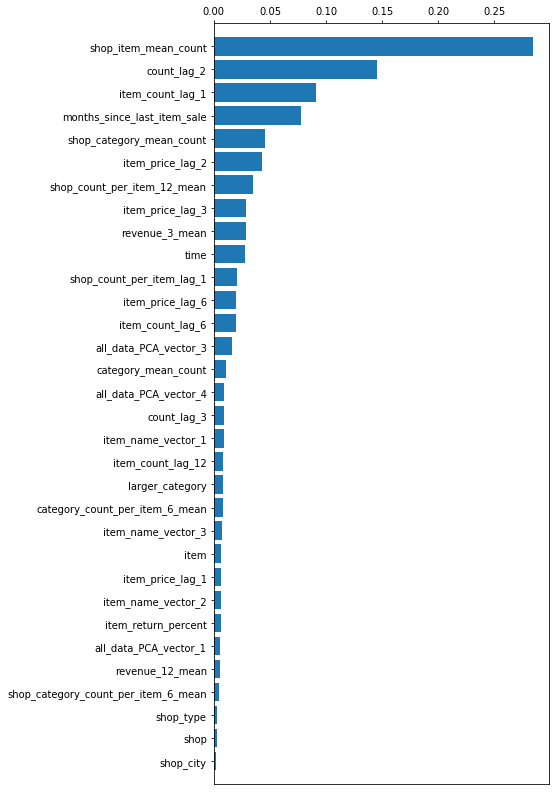

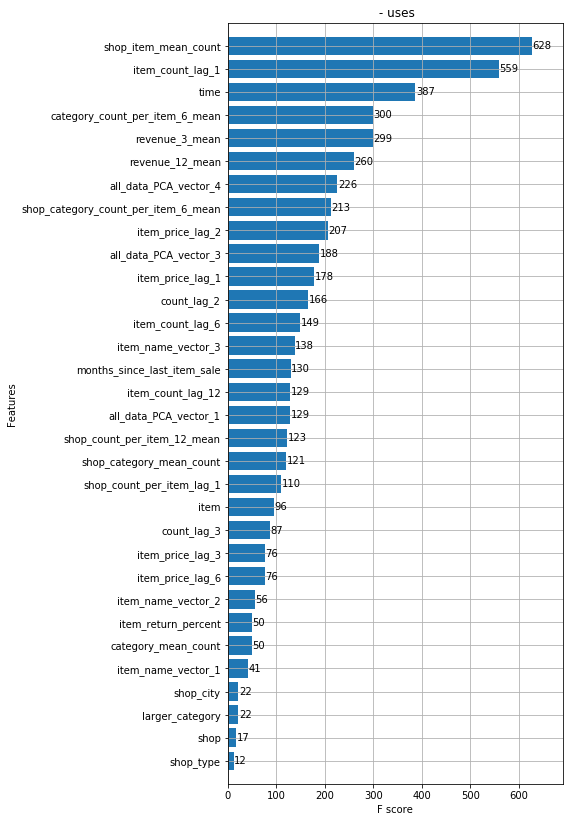

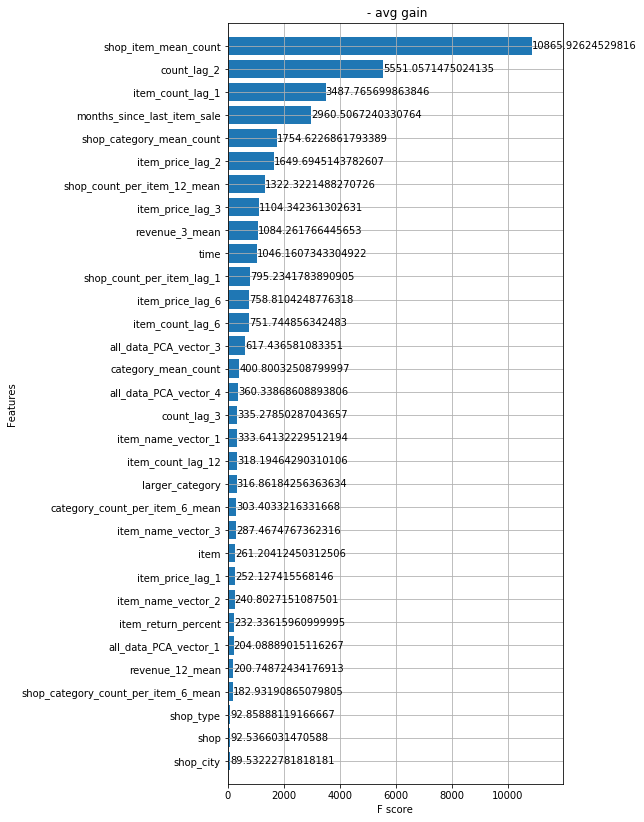

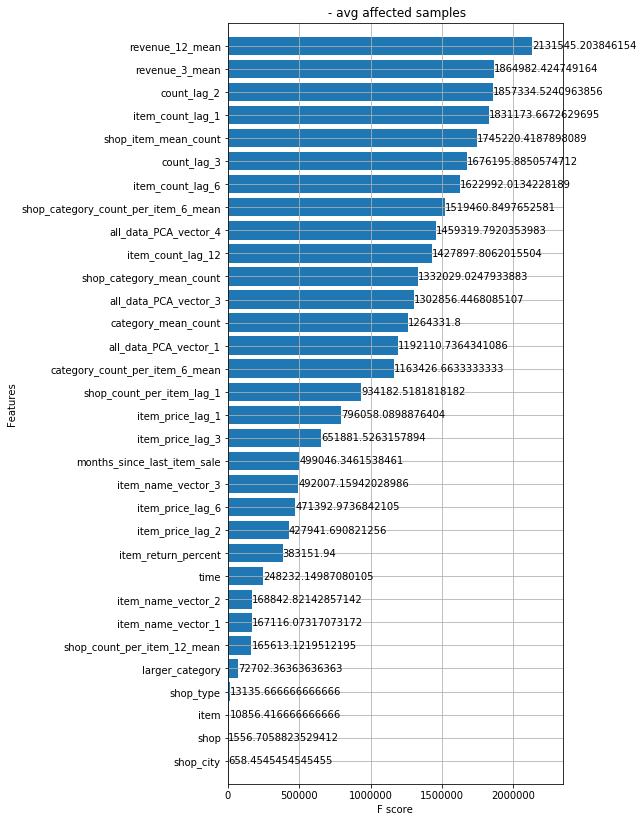

In [4]:
### Development model training

# Data split

train = data[data['time'] <= LAST_TRAINSET_TIME]
validate = data[(data['time'] > LAST_TRAINSET_TIME) & (data['time'] < 34)]

train_X = train.drop('count', axis=1)
train_y = train['count']
del train
validate_X = validate.drop('count', axis=1)
validate_y = validate['count']
del validate
predict = data[data['time'] == 34]
predict_X = predict.drop('count', axis=1)
del predict
del data

for preset in presets:
    
    model_name = preset['model_name']
    model_class = preset['model_class']
    model_params = preset['model_params']
    show_error_bars = model_class == RandomForestRegressor or model_class == ExtraTreesRegressor
    
    print('Model:', model_name)

    # Train

    start = time()
    model = model_class(**model_params)
    
    if model_class == XGBRegressor:
        fit_params = preset['fit_params']
        eval_set = [(train_X, train_y), (validate_X, validate_y)]
        model.fit(train_X, train_y, eval_set=eval_set, verbose=False, **fit_params)
    else:
        model.fit(train_X, train_y)
    
    preset['model'] = model
    print('({} min)'.format(round((time()-start)/60, 1)))
    
    if 'n_iter_no_change' in model_params.keys():
        print('Model contains', len(model.estimators_), 'trees')
    if model_class == XGBRegressor:
        if 'early_stopping_rounds' in fit_params.keys():
            print('Model contains', model.best_iteration+1, 'trees')
            ntree_limit = model.best_ntree_limit
        else:
            ntree_limit = model_params['n_estimators']

    # Validate
    
    if model_class == XGBRegressor:
        train_prediction = model.predict(train_X, ntree_limit=ntree_limit)
        validate_prediction = model.predict(validate_X, ntree_limit=ntree_limit)
    else:
        train_prediction = model.predict(train_X)
        validate_prediction = model.predict(validate_X)

    print('train RMSE: {}'.format(np.sqrt(MSE(train_prediction, train_y))))
    print('validation RMSE: {}'.format(np.sqrt(MSE(validate_prediction, validate_y))))
    
    # Analysis
    
    plot_importances(model, error=show_error_bars, title=model_name)
    if model_class == XGBRegressor:
        plot_xgboost_importances(model, model_name)
    
    if model_class == RandomForestRegressor:
        plot_tree_usefulness(model, validate_X, validate_y, model_name)
        
    print()

In [5]:
print('total time:', round((time()-totalstart)/60, 1), 'min')
print('total time:', round((time()-totalstart)/60/60, 1), 'h')

total time: 110.7 min
total time: 1.8 h


In [6]:
for i, preset in enumerate(presets):
    
    filename = 'data/submission_{}.csv'.format(i)
    model_class = preset['model_class']
    model_name = preset['model_name']
    model = preset['model']
    
    print(filename, model_name)
    
    if model_class == XGBRegressor:
        if 'early_stopping_rounds' in fit_params.keys():
            ntree_limit = model.best_ntree_limit
        else:
            ntree_limit = model_params['n_estimators']
        final_prediction = model.predict(predict_X, ntree_limit=ntree_limit)
    else:
        final_prediction = model.predict(predict_X)
    final_prediction = np.clip(final_prediction, 0, 20)

    prediction = predict_X[['shop', 'item']]
    prediction.columns = ['shop_id', 'item_id']
    prediction['item_cnt_month'] = final_prediction
    prediction = pd.merge(prediction, pd.read_csv('data/test.csv'), how='right')
    prediction['item_cnt_month'].fillna(0, inplace=True) # maybe something better can be done?

    prediction.sort_values(by='ID', inplace=True)
    prediction = prediction[['ID', 'item_cnt_month']]
    
    prediction.to_csv(filename, index=False)

data/submission_0.csv 


C:\Users\Andreas\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
